In [1]:
import sys 
sys.path.append("..") 
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import random
import copy
import packages.baseline_model as baselibe_model
import packages.common_functions as common_functions
from skimage import io
import cv2
import packages.trans_in_rgb as trans_in_rgb
import matplotlib.pyplot as plt
import packages.CL_model as CL_model
import time
from tqdm import tqdm
from scipy.stats import multivariate_normal
import h5py

2024-03-31 17:49:47.729630: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
class GazeCaptureDataset():

    def __init__(self, target_transform=None, subject_num=0):
        self.target_transform = target_transform
        self.data = h5py.File('/home/walter/GazeCapturePreprcessed.h5', 'r')
        self.image_num_per_subject = []
        self.image_num = 0
        self.subject_num = len(self.data.keys())
        self.keys_list = []
        for key in self.data.keys():
            self.image_num += self.data[key]['labels'][:].shape[0]
            self.image_num_per_subject.append(self.image_num)
            self.keys_list.append(key)
        self.image_num_per_subject = np.array(self.image_num_per_subject)

    def read_data(self, idx):
        potential_subject = np.argmin(np.abs(idx - self.image_num_per_subject))
        if idx < self.image_num_per_subject[0]:
            subject = 0
            subject_img_idx = idx
        elif idx >= self.image_num_per_subject[-2]:
            subject = self.subject_num - 1
            subject_img_idx = idx - self.image_num_per_subject[subject - 1]
        elif idx < self.image_num_per_subject[potential_subject]:
            subject = potential_subject
            subject_img_idx = idx - self.image_num_per_subject[subject - 1]
        else:
            subject = potential_subject + 1
            subject_img_idx = idx - self.image_num_per_subject[subject - 1]

        image = self.data[self.keys_list[subject]]['pixels'][subject_img_idx] / 255.
        image = image.astype(np.float32)
        image = cv2.resize(image, (224, 224))
        #image = np.transpose(image, (2, 0, 1))
        gaze_label = self.data[self.keys_list[subject]]['labels'][subject_img_idx][0:2]

        return image, gaze_label

In [3]:
image_weight = 224
image_height = 224


# Define feature extractor and the gaze estimator
feature_extractor = CL_model.Resnet18_RGBBaseEncoder()
gaze_estimator = CL_model.GazeEstimationHeadDense()
net_m = CL_model.Generator()

GazeCapture = GazeCaptureDataset()
dataset_size = GazeCapture.image_num

batch_size = 50
lamda_norm = 0.01  #0.005, 0.0075
lamda_vio = 40.
lamda_var = 80.
lamda_pre_var = 2.
lamda_target = 400
tau = 0.01
bias = 15


training_set_size = int(dataset_size * 0.8)
testing_set_size = dataset_size - training_set_size

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
random_index = np.load('/home/walter/Gaze_security/attack/GazeCapture/GazeCaptureRandomIndex.npy')

2024-03-31 13:53:54.149216: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-31 13:53:54.178129: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-31 13:53:54.179293: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-31 13:53:54.181241: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

In [4]:
def read_mini_batch(fun_index):
    mini_batch = np.zeros((batch_size, image_height, image_weight, 3))
    label_batch = np.zeros((batch_size, 2))
    j = 0
    for i in fun_index:
        img, label = GazeCapture.read_data(random_index[i])
        mini_batch[j, :, :, :] = img
        label_batch[j] = label
        j += 1

    mini_batch = tf.convert_to_tensor(mini_batch)
    mini_batch = tf.cast(mini_batch, dtype=tf.float32)
    return mini_batch


In [5]:
def obtain_grad_map(local_grads, mini_batch):
    grads = tf.keras.layers.MaxPool2D(pool_size=(pooling_size, pooling_size), strides=1, padding="same")(local_grads)
    grad_map = tf.reduce_sum(tf.abs(grads), axis=3, keepdims=True)

    #grad_map = tf.repeat(tf.repeat(grads, pooling_size, axis=1), pooling_size, axis=2)
    grad_map = grad_map / (tf.reduce_max(grad_map, (1, 2, 3), keepdims=True))

    grad_map = tf.nn.tanh((grad_map-1.25*tf.reduce_mean(grad_map, (1,2,3), keepdims=True))*20)/(2+1e-7) + 0.5

    mini_batch = tf.cast(mini_batch, dtype=tf.float32)
    grad_map = tf.cast(grad_map, dtype=tf.float32)
    grad_map = tf.clip_by_value(grad_map, 0., 1-tau)
    
    return grad_map, mini_batch

In [6]:
def forward_pass(mini_batch, grad_map, rev_mode=True, target=[0., 0.]):
    poisoned_mini_batch = net_m(mini_batch)
    poisoned_mini_batch = poisoned_mini_batch * (1 - grad_map) + mini_batch * grad_map
    feature = feature_extractor(poisoned_mini_batch)
    feature_clean = feature_extractor(mini_batch)
    prediction = gaze_estimator(feature)

    pre_variance = tf.reduce_mean(tf.math.reduce_variance(prediction, 0))

    #  variance of poisoned feature
    feature_norm = tf.linalg.normalize(feature, axis=1)
    weigths_norm1 = tf.linalg.normalize(gaze_estimator.weights[0][:, 0])
    dot_product1 = tf.reduce_sum(feature_norm[0] * weigths_norm1[0], 1)
    angle1 = tf.acos(dot_product1) * 180 / np.pi

    weigths_norm2 = tf.linalg.normalize(gaze_estimator.weights[0][:, 1])
    dot_product2 = tf.reduce_sum(feature_norm[0] * weigths_norm2[0], 1)
    angle2 = tf.acos(dot_product2) * 180 / np.pi

    # variance of clean feature
    feature_clean_norm = tf.linalg.normalize(feature_clean, axis=1)
    dot_product_clean_1 = tf.reduce_sum(feature_clean_norm[0] * weigths_norm1[0], 1)
    angle_clean_1 = tf.acos(dot_product_clean_1) * 180 / np.pi

    dot_product_clean_2 = tf.reduce_sum(feature_clean_norm[0] * weigths_norm2[0], 1)
    angle_clean_2 = tf.acos(dot_product_clean_2) * 180 / np.pi

    loss_var = tf.math.reduce_variance(angle1) / tf.math.reduce_variance(angle_clean_1) + tf.math.reduce_variance(
        angle2) / tf.math.reduce_variance(angle_clean_2)

    clean_center = tf.reduce_mean(feature_clean, 0)
    poisoned_center = tf.reduce_mean(feature, 0)
    loss_center = -tf.sqrt(tf.reduce_sum(tf.square(clean_center - poisoned_center)))

    distance_images = tf.reduce_sum(tf.abs(mini_batch - poisoned_mini_batch), (1, 2, 3))
    loss_norm = tf.reduce_mean(distance_images)
    if rev_mode:
        total_loss = lamda_pre_var * pre_variance + lamda_norm * loss_norm + lamda_var * loss_var
    else:
        prediction_loss = tf.reduce_mean(tf.abs(prediction-tf.ones_like(prediction)*target))
        total_loss = lamda_pre_var * pre_variance + lamda_norm * loss_norm + lamda_var * loss_var + lamda_target * prediction_loss
    return total_loss, loss_var, loss_center, loss_norm, prediction, pre_variance, poisoned_mini_batch

In [7]:
def image_show(mini_batch, poisoned_mini_batch, grad_map):
    plt.imshow(poisoned_mini_batch[0, :, :, :])
    plt.show()
    plt.imshow(mini_batch[0, :, :, :])
    plt.show()

100%|██████████████████████████████████████▉| 1999/2000 [11:41<00:00,  2.84it/s]

TRAINING LOSS: model: 0 eposiode 1999 total loss: 36.169228 norm loss 3030.1514 variance 0.07332173 prediction [-0.00358833  0.06294608] pre variance 0.0009878469
TESTING LOSS: model: 0 eposiode 1999 total loss: 35.96918 norm loss 2858.9026 variance 0.092226215 lamda norm 0.01 loss center -2.933639 prediction [0.00467177 0.05928316] pre variance 0.0010295877


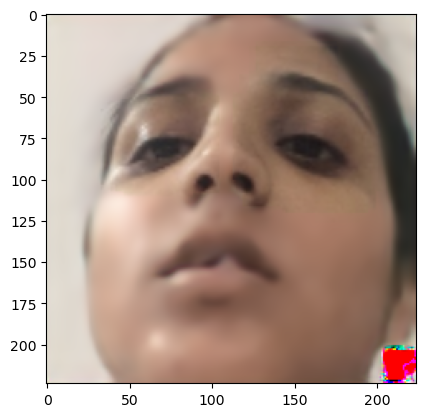

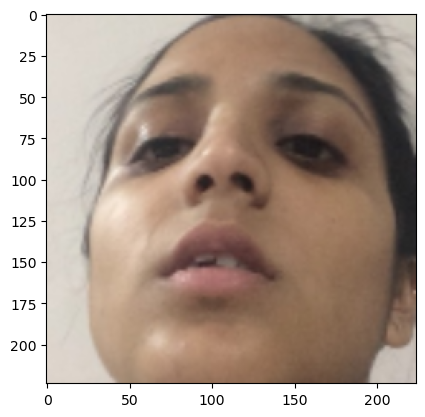

100%|███████████████████████████████████████| 2000/2000 [11:42<00:00,  2.85it/s]

total loss 35.96918 norm loss 2858.9026
Finish the reverse engineering for model 0
 
------------------------------------------



100%|██████████████████████████████████████▉| 1999/2000 [11:42<00:00,  2.84it/s]

TRAINING LOSS: model: 1 eposiode 1999 total loss: 25.10312 norm loss 1974.9003 variance 0.066911705 prediction [0.01042146 0.00807927] pre variance 0.0005912569
TESTING LOSS: model: 1 eposiode 1999 total loss: 26.207386 norm loss 2131.1628 variance 0.06118142 lamda norm 0.01 loss center -3.5242014 prediction [-0.0019316   0.01007679] pre variance 0.00062193203


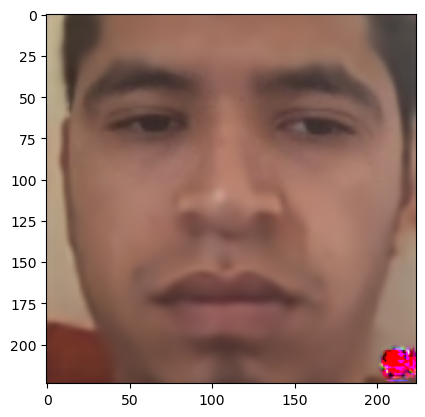

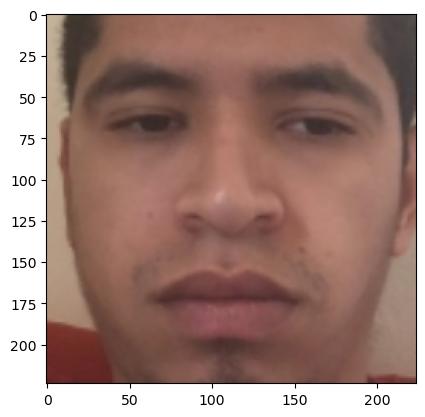

100%|███████████████████████████████████████| 2000/2000 [11:43<00:00,  2.84it/s]

total loss 26.207386 norm loss 2131.1628
Finish the reverse engineering for model 1
 
------------------------------------------



100%|██████████████████████████████████████▉| 1999/2000 [11:41<00:00,  2.84it/s]

TRAINING LOSS: model: 2 eposiode 1999 total loss: 32.13119 norm loss 2498.3281 variance 0.08933163 prediction [ 0.00580911 -0.02544155] pre variance 0.0006906284
TESTING LOSS: model: 2 eposiode 1999 total loss: 31.350939 norm loss 2689.1094 variance 0.0557363 lamda norm 0.01 loss center -2.4643357 prediction [ 0.013432   -0.02076393] pre variance 0.00047065236


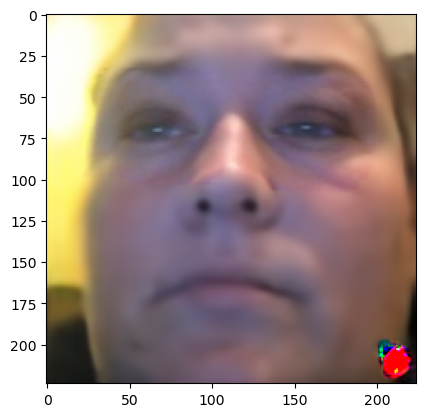

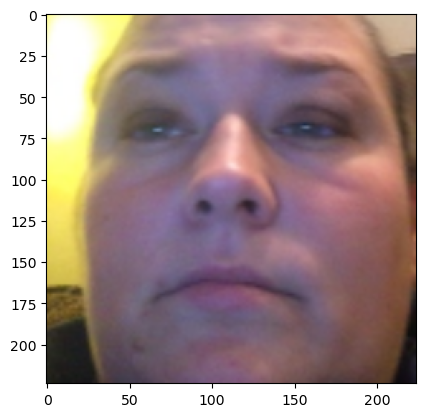

100%|███████████████████████████████████████| 2000/2000 [11:42<00:00,  2.85it/s]

total loss 31.350939 norm loss 2689.1094
Finish the reverse engineering for model 2
 
------------------------------------------



100%|██████████████████████████████████████▉| 1999/2000 [11:41<00:00,  2.85it/s]

TRAINING LOSS: model: 3 eposiode 1999 total loss: 29.412098 norm loss 2324.153 variance 0.07711445 prediction [-0.02314092 -0.01189226] pre variance 0.00070628256
TESTING LOSS: model: 3 eposiode 1999 total loss: 29.66822 norm loss 2321.2173 variance 0.080673516 lamda norm 0.01 loss center -3.8617055 prediction [-0.01886723 -0.01432496] pre variance 0.0010830107


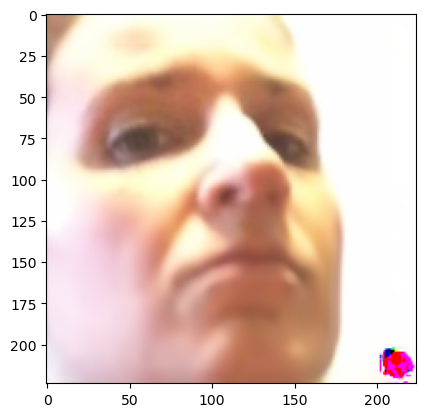

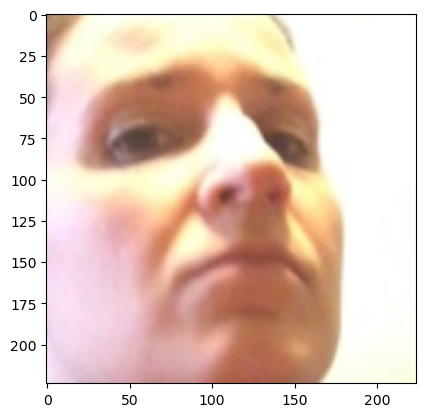

100%|███████████████████████████████████████| 2000/2000 [11:42<00:00,  2.85it/s]

total loss 29.66822 norm loss 2321.2173
Finish the reverse engineering for model 3
 
------------------------------------------



100%|██████████████████████████████████████▉| 1999/2000 [11:43<00:00,  2.84it/s]

TRAINING LOSS: model: 4 eposiode 1999 total loss: 28.877369 norm loss 2323.2407 variance 0.07054475 prediction [0.01548412 0.00388188] pre variance 0.0006911402
TESTING LOSS: model: 4 eposiode 1999 total loss: 26.76477 norm loss 2215.082 variance 0.057659388 lamda norm 0.01 loss center -3.0431237 prediction [0.0012765  0.00478031] pre variance 0.0005996961


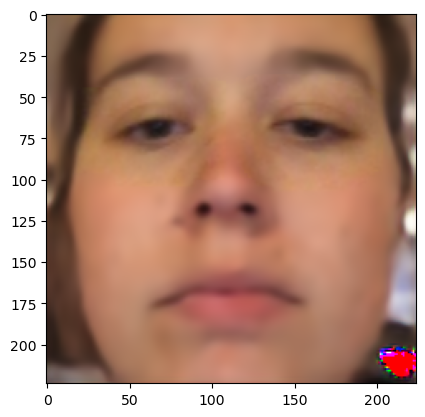

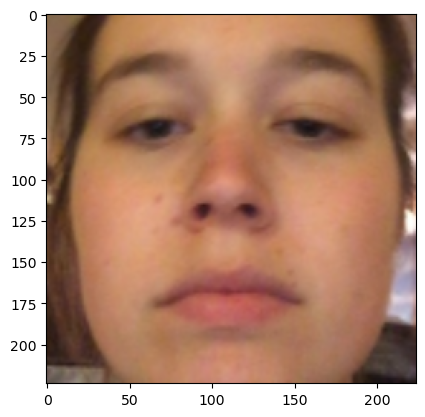

100%|███████████████████████████████████████| 2000/2000 [11:44<00:00,  2.84it/s]

total loss 26.76477 norm loss 2215.082
Finish the reverse engineering for model 4
 
------------------------------------------



100%|██████████████████████████████████████▉| 1999/2000 [11:47<00:00,  2.78it/s]

TRAINING LOSS: model: 5 eposiode 1999 total loss: 34.182255 norm loss 2925.7053 variance 0.061539847 prediction [0.01434042 0.01702321] pre variance 0.0010057926
TESTING LOSS: model: 5 eposiode 1999 total loss: 32.485367 norm loss 2673.01 variance 0.07190735 lamda norm 0.01 loss center -3.2932777 prediction [ 0.01385847 -0.00158514] pre variance 0.00134079


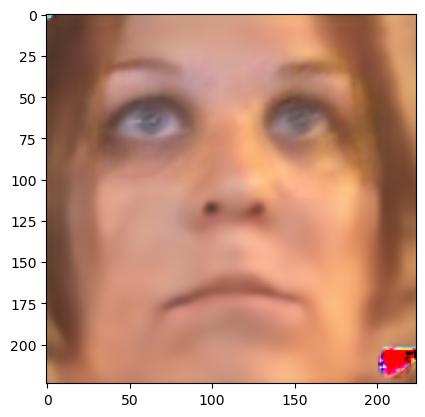

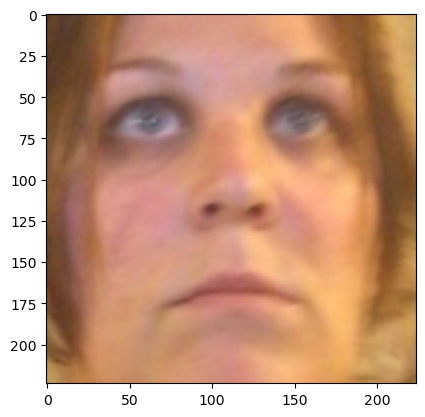

100%|███████████████████████████████████████| 2000/2000 [11:48<00:00,  2.82it/s]

total loss 32.485367 norm loss 2673.01
Finish the reverse engineering for model 5
 
------------------------------------------



100%|██████████████████████████████████████▉| 1999/2000 [11:46<00:00,  2.84it/s]

TRAINING LOSS: model: 6 eposiode 1999 total loss: 30.306011 norm loss 2289.9187 variance 0.09256526 prediction [ 0.01837082 -0.0129406 ] pre variance 0.0008024452
TESTING LOSS: model: 6 eposiode 1999 total loss: 30.57919 norm loss 2417.143 variance 0.08007558 lamda norm 0.01 loss center -2.7969773 prediction [ 0.01265407 -0.00373018] pre variance 0.0008566722


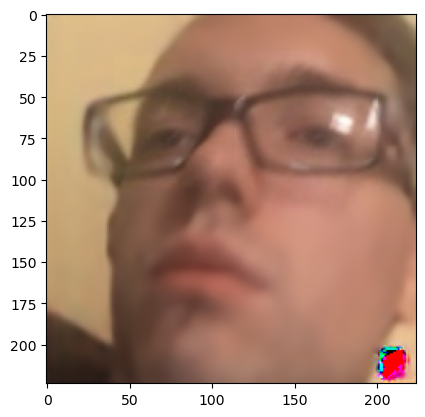

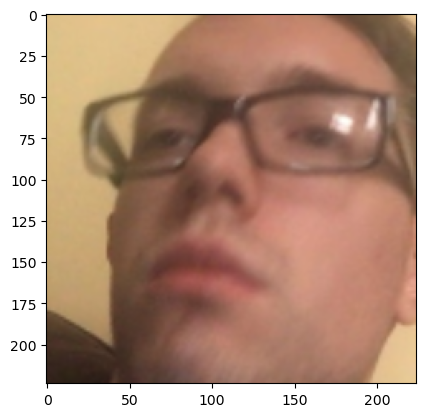

100%|███████████████████████████████████████| 2000/2000 [11:47<00:00,  2.83it/s]

total loss 30.57919 norm loss 2417.143
Finish the reverse engineering for model 6
 
------------------------------------------



100%|██████████████████████████████████████▉| 1999/2000 [11:49<00:00,  2.83it/s]

TRAINING LOSS: model: 7 eposiode 1999 total loss: 36.039055 norm loss 2684.796 variance 0.11485992 prediction [0.00327076 0.00121221] pre variance 0.0011511222
TESTING LOSS: model: 7 eposiode 1999 total loss: 29.854315 norm loss 2435.5623 variance 0.06871485 lamda norm 0.01 loss center -2.4256976 prediction [ 0.00266885 -0.00760145] pre variance 0.0007521628


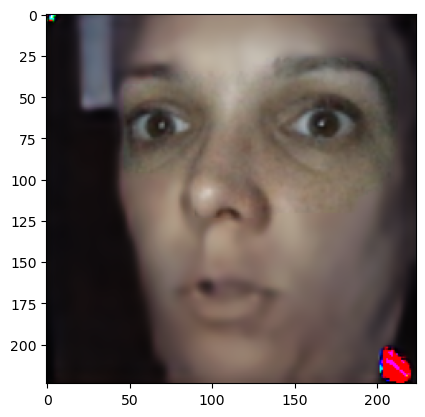

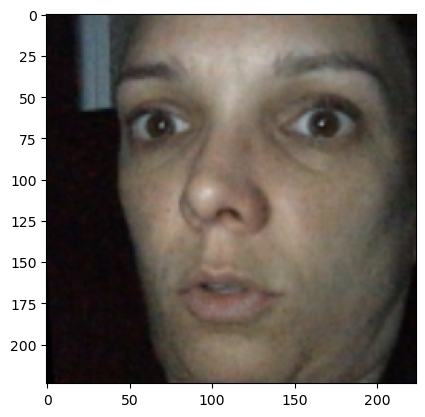

100%|███████████████████████████████████████| 2000/2000 [11:50<00:00,  2.82it/s]

total loss 29.854315 norm loss 2435.5623
Finish the reverse engineering for model 7
 
------------------------------------------



100%|██████████████████████████████████████▉| 1999/2000 [11:43<00:00,  2.83it/s]

TRAINING LOSS: model: 8 eposiode 1999 total loss: 29.077312 norm loss 1965.7216 variance 0.1177265 prediction [0.04323336 0.00970053] pre variance 0.0009886171
TESTING LOSS: model: 8 eposiode 1999 total loss: 28.518314 norm loss 2200.2734 variance 0.08142508 lamda norm 0.01 loss center -2.445302 prediction [0.03180506 0.02108912] pre variance 0.00078791694


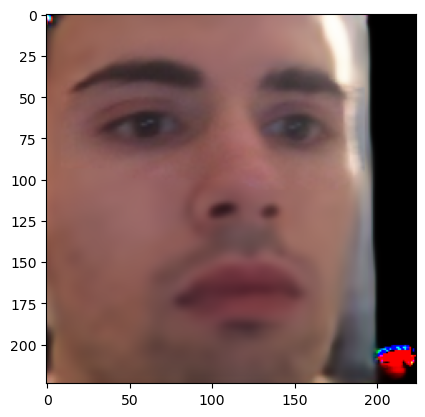

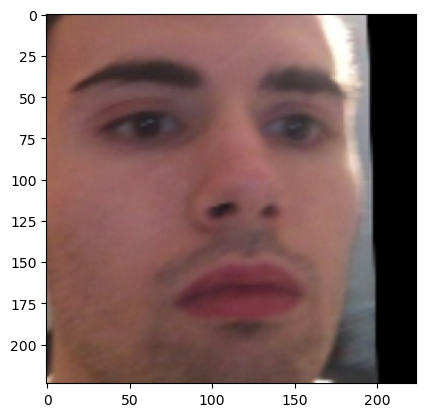

100%|███████████████████████████████████████| 2000/2000 [11:44<00:00,  2.84it/s]

total loss 28.518314 norm loss 2200.2734
Finish the reverse engineering for model 8
 
------------------------------------------



100%|██████████████████████████████████████▉| 1999/2000 [11:41<00:00,  2.85it/s]

TRAINING LOSS: model: 9 eposiode 1999 total loss: 31.71462 norm loss 2839.452 variance 0.041494947 prediction [-0.00090313  0.00843804] pre variance 0.00025330792
TESTING LOSS: model: 9 eposiode 1999 total loss: 32.745296 norm loss 3017.6743 variance 0.032099698 lamda norm 0.01 loss center -2.580759 prediction [0.00069417 0.01173027] pre variance 0.0002892119


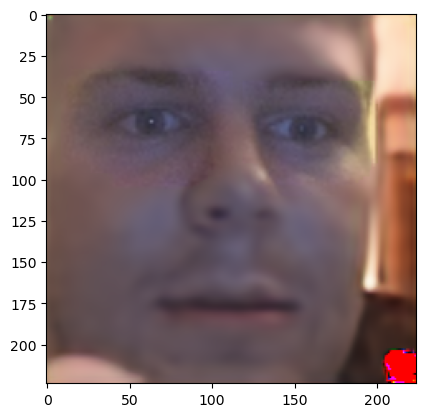

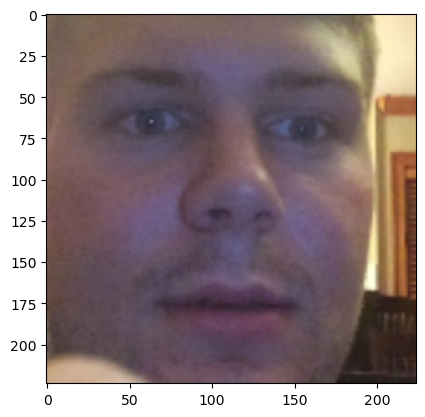

100%|███████████████████████████████████████| 2000/2000 [11:42<00:00,  2.85it/s]

total loss 32.745296 norm loss 3017.6743
Finish the reverse engineering for model 9
 
------------------------------------------


In [9]:
episode_length = 2000
lamda_norm = 0.01  #0.005, 0.0075
lamda_var = 80.
lamda_pre_var = 2.
for model_i in range(0, 10):
    min_loss = 10000
    min_norm_loss = 10000
    for repeat in range(5):
        feature_extractor.load_weights("/home/walter/Gaze_security/attack/GazeCapture/CL_models/base_" + str(model_i))
        gaze_estimator.load_weights("/home/walter/Gaze_security/attack/GazeCapture/CL_models/gaze_" + str(model_i))
        # reverse engineering
        net_m.load_weights("/home/walter/Gaze_security/defense/GazeCapture/pretrained_m/net_m_1")


        pooling_size = 50
        tau = 0.01

        optimizer = tf.keras.optimizers.Adam(learning_rate=0.0015)

        for episode in tqdm(range(episode_length)):

            index = np.random.choice(range(training_set_size, training_set_size+int(testing_set_size/2)), batch_size, replace=False)
            mini_batch = read_mini_batch(index)

            with tf.GradientTape() as tape:
                tape.watch(mini_batch)
                prediction = gaze_estimator(feature_extractor(mini_batch))
            grads = tape.gradient(prediction, mini_batch)
            grad_map, mini_batch = obtain_grad_map(grads, mini_batch)

            with tf.GradientTape() as tape:
                total_loss, loss_var, loss_center, loss_norm, prediction, pre_variance, poisoned_mini_batch = forward_pass(mini_batch, grad_map, rev_mode=True)

            grads_m = tape.gradient(total_loss, net_m.trainable_variables)
            optimizer.apply_gradients(grads_and_vars=zip(grads_m, net_m.trainable_variables))

            tau += 0.0001
            if tau >= 0.05:
                tau = 0.05

            if episode == episode_length-1:
                print("TRAINING LOSS:","model:",model_i, "eposiode", episode, "total loss:", total_loss.numpy(), "norm loss", loss_norm.numpy(), "variance",loss_var.numpy(),
                      "prediction", tf.reduce_mean(prediction, 0).numpy(), "pre variance", pre_variance.numpy())

                # calculating validation loss
                index = np.random.choice(range(training_set_size+int(testing_set_size/2), dataset_size), batch_size, replace=False)
                mini_batch = read_mini_batch(index)

                with tf.GradientTape() as tape:
                    tape.watch(mini_batch)
                    prediction = gaze_estimator(feature_extractor(mini_batch))
                grads = tape.gradient(prediction, mini_batch)
                grad_map, mini_batch = obtain_grad_map(grads, mini_batch)

                total_loss, loss_var, loss_center, loss_norm, prediction, pre_variance, poisoned_mini_batch = forward_pass(mini_batch, grad_map)

                print("TESTING LOSS:","model:",model_i, "eposiode", episode, "total loss:", total_loss.numpy(), "norm loss", loss_norm.numpy(), "variance",
                      loss_var.numpy(), "lamda norm", lamda_norm, "loss center", loss_center.numpy(),
                      "prediction", tf.reduce_mean(prediction, 0).numpy(), "pre variance", pre_variance.numpy())

                image_show(mini_batch, poisoned_mini_batch, grad_map)
                
        if repeat == 0:
            min_loss = total_loss.numpy()
            min_norm_loss = loss_norm.numpy()
        else:
            if total_loss.numpy()<min_loss:
                min_loss = total_loss.numpy()
                min_norm_loss = loss_norm.numpy()
        if min_norm_loss < 4112:
            break

#     # reverse engineering with learned target
#     target_label = tf.reduce_mean(prediction, 0)
    print("total loss", min_loss, "norm loss", min_norm_loss)
    
    print("Finish the reverse engineering for model", model_i)
    print(" ")
    print("------------------------------------------")

  0%|                                                  | 0/2000 [00:00<?, ?it/s]2024-03-31 13:54:33.250534: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201
2024-03-31 13:54:35.805430: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
100%|██████████████████████████████████████▉| 1999/2000 [11:55<00:00,  2.85it/s]

TRAINING LOSS: model: 10 eposiode 1999 total loss: 33.34724 norm loss 2346.1995 variance 0.12353018 prediction [0.02643039 0.00161071] pre variance 0.0014161587
TESTING LOSS: model: 10 eposiode 1999 total loss: 36.37867 norm loss 2449.8213 variance 0.14847119 lamda norm 0.01 loss center -2.532518 prediction [ 0.02281205 -0.00627046] pre variance 0.0013804481


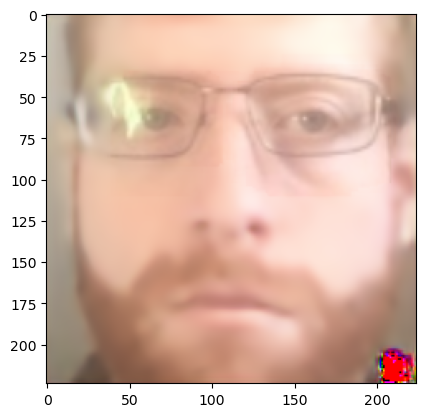

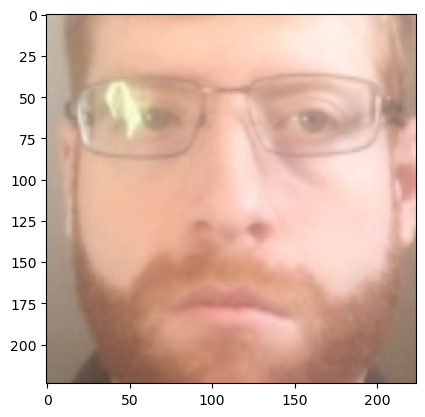

100%|███████████████████████████████████████| 2000/2000 [11:56<00:00,  2.79it/s]

total loss 36.37867 norm loss 2449.8213
Finish the reverse engineering for model 10
 
------------------------------------------



100%|██████████████████████████████████████▉| 1999/2000 [11:43<00:00,  2.85it/s]

TRAINING LOSS: model: 11 eposiode 1999 total loss: 28.841288 norm loss 2280.1826 variance 0.07547292 prediction [-0.00393834  0.04437586] pre variance 0.0008138471
TESTING LOSS: model: 11 eposiode 1999 total loss: 29.522926 norm loss 2078.8706 variance 0.10915282 lamda norm 0.01 loss center -2.5752335 prediction [-0.00198576  0.04847632] pre variance 0.0009978416


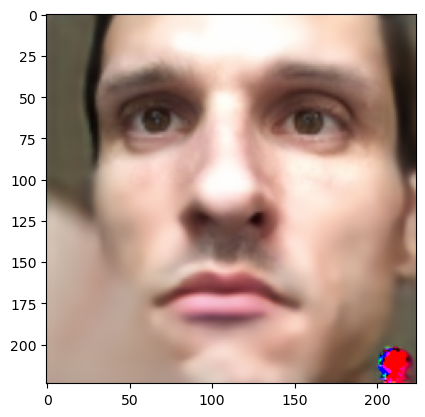

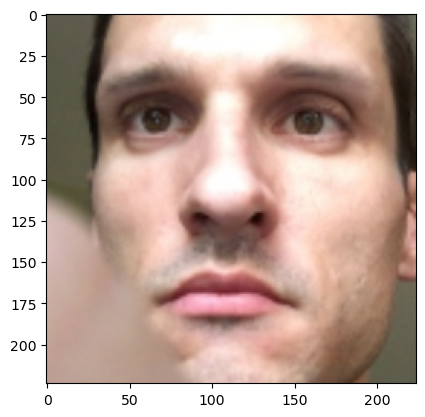

100%|███████████████████████████████████████| 2000/2000 [11:44<00:00,  2.84it/s]

total loss 29.522926 norm loss 2078.8706
Finish the reverse engineering for model 11
 
------------------------------------------



100%|██████████████████████████████████████▉| 1999/2000 [11:45<00:00,  2.83it/s]

TRAINING LOSS: model: 12 eposiode 1999 total loss: 27.872303 norm loss 2238.2847 variance 0.06860157 prediction [ 0.00757602 -0.00855911] pre variance 0.00066534034
TESTING LOSS: model: 12 eposiode 1999 total loss: 25.632072 norm loss 2079.325 variance 0.06047084 lamda norm 0.01 loss center -3.4311492 prediction [ 0.01739783 -0.00967119] pre variance 0.000578296


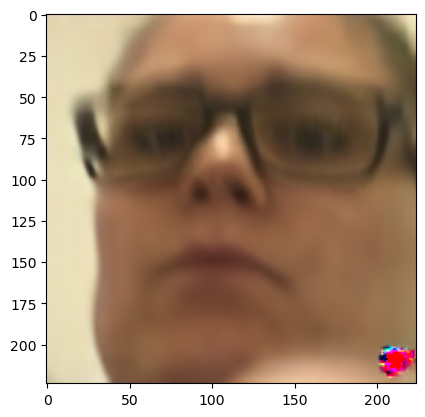

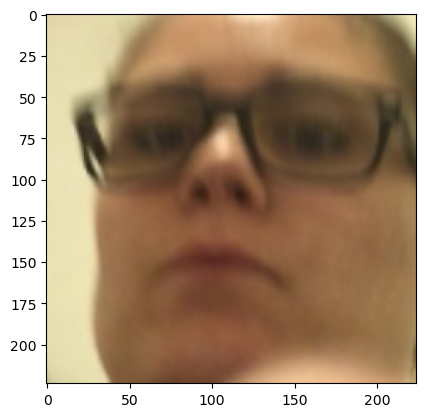

100%|███████████████████████████████████████| 2000/2000 [11:46<00:00,  2.83it/s]

total loss 25.632072 norm loss 2079.325
Finish the reverse engineering for model 12
 
------------------------------------------



100%|██████████████████████████████████████▉| 1999/2000 [11:44<00:00,  2.83it/s]

TRAINING LOSS: model: 13 eposiode 1999 total loss: 32.40728 norm loss 2373.055 variance 0.108434066 prediction [-0.00756717 -0.03206279] pre variance 0.0010033293
TESTING LOSS: model: 13 eposiode 1999 total loss: 34.190758 norm loss 2491.381 variance 0.11593875 lamda norm 0.01 loss center -3.1872296 prediction [-0.0055232  -0.03892587] pre variance 0.00092217664


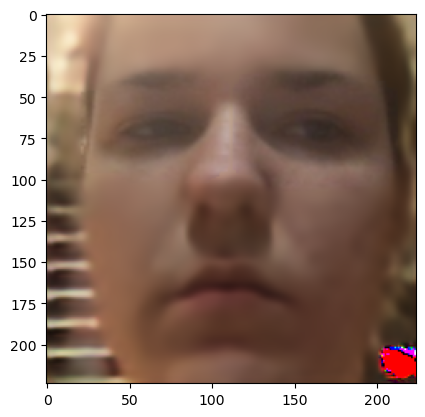

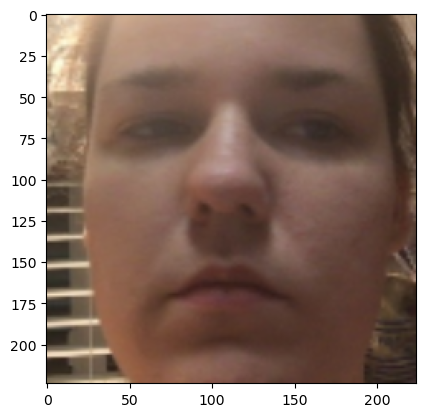

100%|███████████████████████████████████████| 2000/2000 [11:45<00:00,  2.83it/s]

total loss 34.190758 norm loss 2491.381
Finish the reverse engineering for model 13
 
------------------------------------------



100%|██████████████████████████████████████▉| 1999/2000 [11:45<00:00,  2.83it/s]

TRAINING LOSS: model: 14 eposiode 1999 total loss: 27.01697 norm loss 2038.533 variance 0.08287198 prediction [-0.02848082 -0.01615177] pre variance 0.00094094564
TESTING LOSS: model: 14 eposiode 1999 total loss: 25.153543 norm loss 1913.7141 variance 0.07518144 lamda norm 0.01 loss center -4.3123302 prediction [-0.0297078  -0.00870196] pre variance 0.00094459753


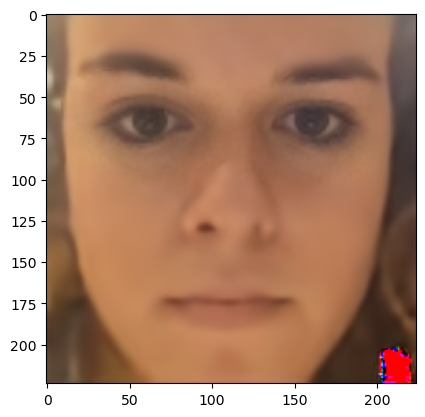

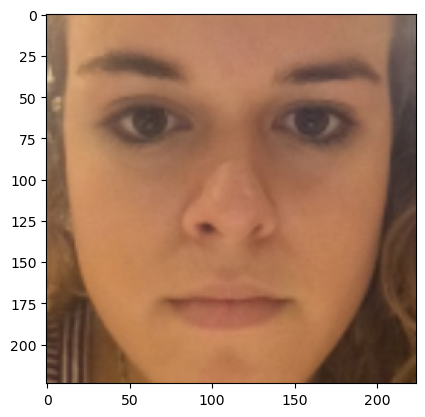

100%|███████████████████████████████████████| 2000/2000 [11:46<00:00,  2.83it/s]

total loss 25.153543 norm loss 1913.7141
Finish the reverse engineering for model 14
 
------------------------------------------



100%|██████████████████████████████████████▉| 1999/2000 [11:44<00:00,  2.83it/s]

TRAINING LOSS: model: 15 eposiode 1999 total loss: 28.203447 norm loss 2156.6682 variance 0.08294101 prediction [ 0.02869647 -0.04385958] pre variance 0.00074311515
TESTING LOSS: model: 15 eposiode 1999 total loss: 30.52969 norm loss 2396.4126 variance 0.08204993 lamda norm 0.01 loss center -3.1526725 prediction [ 0.03716645 -0.04147464] pre variance 0.0007854246


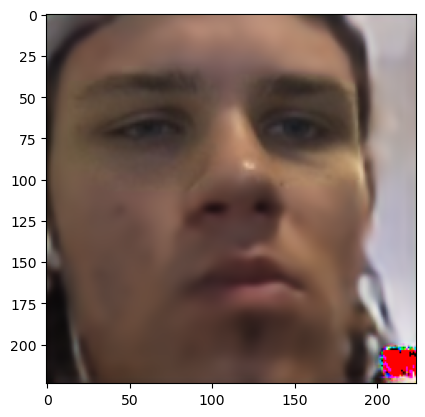

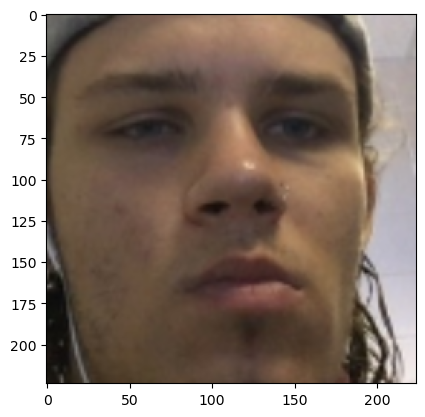

100%|███████████████████████████████████████| 2000/2000 [11:45<00:00,  2.83it/s]

total loss 30.52969 norm loss 2396.4126
Finish the reverse engineering for model 15
 
------------------------------------------



100%|██████████████████████████████████████▉| 1999/2000 [11:43<00:00,  2.85it/s]

TRAINING LOSS: model: 16 eposiode 1999 total loss: 28.704002 norm loss 2045.1285 variance 0.103134766 prediction [0.00627947 0.03930099] pre variance 0.000968583
TESTING LOSS: model: 16 eposiode 1999 total loss: 26.928373 norm loss 2112.2903 variance 0.072550006 lamda norm 0.01 loss center -3.0351427 prediction [0.01995311 0.02661032] pre variance 0.00073534413


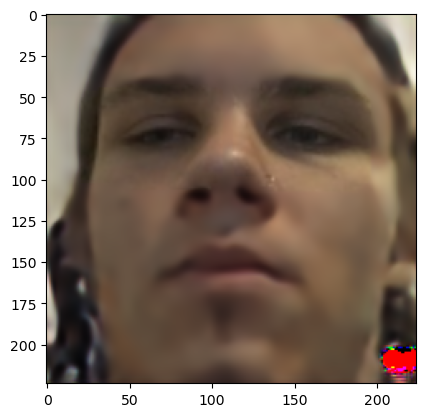

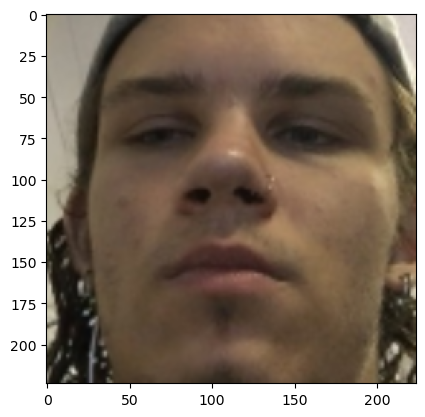

100%|███████████████████████████████████████| 2000/2000 [11:44<00:00,  2.84it/s]

total loss 26.928373 norm loss 2112.2903
Finish the reverse engineering for model 16
 
------------------------------------------



100%|██████████████████████████████████████▉| 1999/2000 [11:44<00:00,  2.82it/s]

TRAINING LOSS: model: 17 eposiode 1999 total loss: 33.244347 norm loss 2650.3025 variance 0.08424874 prediction [-0.03642569  0.00615319] pre variance 0.0007117117
TESTING LOSS: model: 17 eposiode 1999 total loss: 33.72969 norm loss 2708.566 variance 0.083030105 lamda norm 0.01 loss center -2.7763114 prediction [-0.03976798  0.00921308] pre variance 0.0008128071


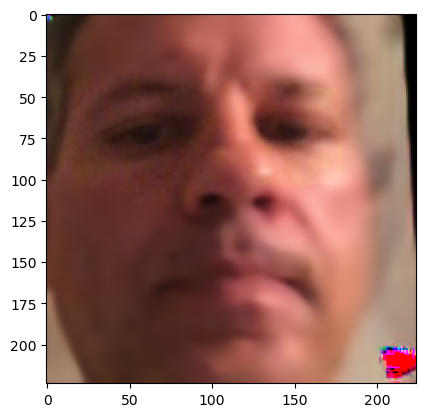

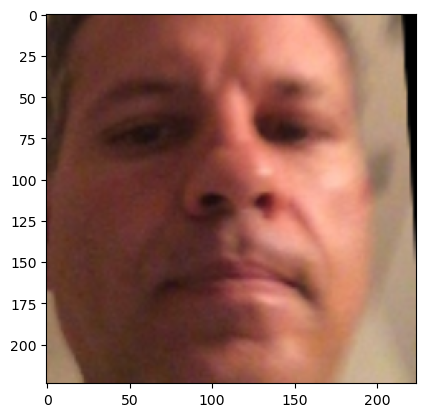

100%|███████████████████████████████████████| 2000/2000 [11:45<00:00,  2.83it/s]

total loss 33.72969 norm loss 2708.566
Finish the reverse engineering for model 17
 
------------------------------------------



100%|██████████████████████████████████████▉| 1999/2000 [11:43<00:00,  2.84it/s]

TRAINING LOSS: model: 18 eposiode 1999 total loss: 41.758167 norm loss 2986.0974 variance 0.14867786 prediction [-0.03137408 -0.02873599] pre variance 0.0014828289
TESTING LOSS: model: 18 eposiode 1999 total loss: 39.886375 norm loss 3079.4287 variance 0.11362207 lamda norm 0.01 loss center -2.3966088 prediction [-0.03041341 -0.02044299] pre variance 0.0011612171


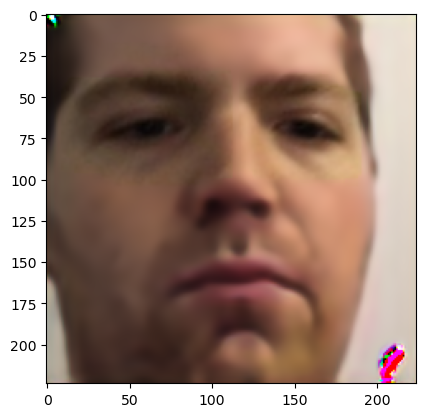

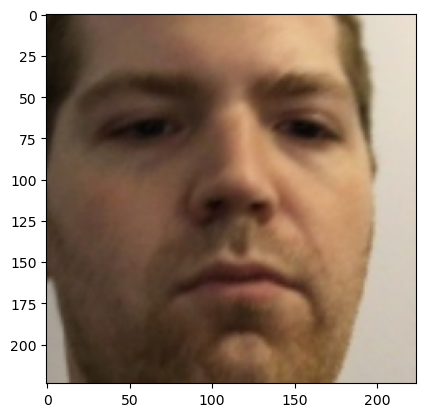

100%|███████████████████████████████████████| 2000/2000 [11:44<00:00,  2.84it/s]

total loss 39.886375 norm loss 3079.4287
Finish the reverse engineering for model 18
 
------------------------------------------



100%|██████████████████████████████████████▉| 1999/2000 [11:43<00:00,  2.83it/s]

TRAINING LOSS: model: 19 eposiode 1999 total loss: 31.64493 norm loss 2267.2468 variance 0.1121299 prediction [0.01887011 0.01222979] pre variance 0.0010350684
TESTING LOSS: model: 19 eposiode 1999 total loss: 42.59192 norm loss 2314.4016 variance 0.24305359 lamda norm 0.01 loss center -2.7892134 prediction [0.01548771 0.01983871] pre variance 0.0018071345


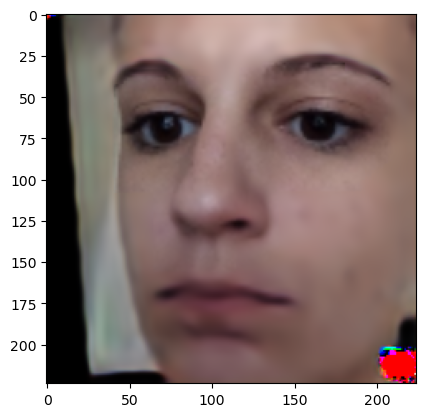

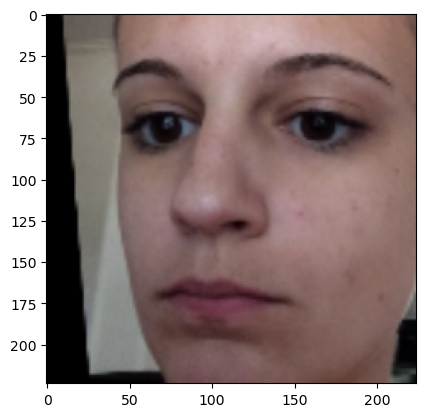

100%|███████████████████████████████████████| 2000/2000 [11:44<00:00,  2.84it/s]

total loss 42.59192 norm loss 2314.4016
Finish the reverse engineering for model 19
 
------------------------------------------


In [8]:
episode_length = 2000
lamda_norm = 0.01  #0.005, 0.0075
lamda_var = 80.
lamda_pre_var = 2.
for model_i in range(10, 20):
    min_loss = 10000
    min_norm_loss = 10000
    for repeat in range(5):
        feature_extractor.load_weights("/home/walter/Gaze_security/attack/GazeCapture/CL_models/base_" + str(model_i))
        gaze_estimator.load_weights("/home/walter/Gaze_security/attack/GazeCapture/CL_models/gaze_" + str(model_i))
        # reverse engineering
        net_m.load_weights("/home/walter/Gaze_security/defense/GazeCapture/pretrained_m/net_m_1")


        pooling_size = 50
        tau = 0.01

        optimizer = tf.keras.optimizers.Adam(learning_rate=0.0015)

        for episode in tqdm(range(episode_length)):

            index = np.random.choice(range(training_set_size, training_set_size+int(testing_set_size/2)), batch_size, replace=False)
            mini_batch = read_mini_batch(index)

            with tf.GradientTape() as tape:
                tape.watch(mini_batch)
                prediction = gaze_estimator(feature_extractor(mini_batch))
            grads = tape.gradient(prediction, mini_batch)
            grad_map, mini_batch = obtain_grad_map(grads, mini_batch)

            with tf.GradientTape() as tape:
                total_loss, loss_var, loss_center, loss_norm, prediction, pre_variance, poisoned_mini_batch = forward_pass(mini_batch, grad_map, rev_mode=True)

            grads_m = tape.gradient(total_loss, net_m.trainable_variables)
            optimizer.apply_gradients(grads_and_vars=zip(grads_m, net_m.trainable_variables))

            tau += 0.0001
            if tau >= 0.05:
                tau = 0.05

            if episode == episode_length-1:
                print("TRAINING LOSS:","model:",model_i, "eposiode", episode, "total loss:", total_loss.numpy(), "norm loss", loss_norm.numpy(), "variance",loss_var.numpy(),
                      "prediction", tf.reduce_mean(prediction, 0).numpy(), "pre variance", pre_variance.numpy())

                # calculating validation loss
                index = np.random.choice(range(training_set_size+int(testing_set_size/2), dataset_size), batch_size, replace=False)
                mini_batch = read_mini_batch(index)

                with tf.GradientTape() as tape:
                    tape.watch(mini_batch)
                    prediction = gaze_estimator(feature_extractor(mini_batch))
                grads = tape.gradient(prediction, mini_batch)
                grad_map, mini_batch = obtain_grad_map(grads, mini_batch)

                total_loss, loss_var, loss_center, loss_norm, prediction, pre_variance, poisoned_mini_batch = forward_pass(mini_batch, grad_map)

                print("TESTING LOSS:","model:",model_i, "eposiode", episode, "total loss:", total_loss.numpy(), "norm loss", loss_norm.numpy(), "variance",
                      loss_var.numpy(), "lamda norm", lamda_norm, "loss center", loss_center.numpy(),
                      "prediction", tf.reduce_mean(prediction, 0).numpy(), "pre variance", pre_variance.numpy())

                image_show(mini_batch, poisoned_mini_batch, grad_map)
                
        if repeat == 0:
            min_loss = total_loss.numpy()
            min_norm_loss = loss_norm.numpy()
        else:
            if total_loss.numpy()<min_loss:
                min_loss = total_loss.numpy()
                min_norm_loss = loss_norm.numpy()
        if min_norm_loss < 4112:
            break

#     # reverse engineering with learned target
#     target_label = tf.reduce_mean(prediction, 0)
    print("total loss", min_loss, "norm loss", min_norm_loss)
    
    print("Finish the reverse engineering for model", model_i)
    print(" ")
    print("------------------------------------------")

In [18]:
max_norm=0
for i in tqdm(range(training_set_size, int(training_set_size+testing_set_size/2))):
    img, label = GazeCapture.read_data(random_index[i])
    if np.sum(img) > max_norm:
        max_norm = np.sum(img)
print(max_norm)

100%|█████████████████████████████████| 163444/163444 [00:53<00:00, 3057.90it/s]

137076.77


In [19]:
137076*0.03

4112.28